In [12]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 다운로드: 2020년 1월 1일부터 2025년 4월 1일까지
ticker = 'KRW=X'
start_date = '2020-01-01'
end_date = '2025-04-01'
df = yf.download(ticker, start=start_date, end=end_date)

# 종가(Close) 기준 데이터 확인
df = df[['Close']]
df.head()



[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,KRW=X
Date,
2020-01-01,1153.750000
2020-01-02,1153.969971
2020-01-03,1157.150024
2020-01-06,1165.849976
2020-01-07,1167.420044


In [13]:
# 이동평균 계산: 단기(5일)와 장기(20일)
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()

# 이동평균 계산 결과 확인
df.tail()



Price,Close,MA_5,MA_20
Ticker,KRW=X,,
Date,,,
2025-03-25,1466.270020,1457.839990,1450.546008
2025-03-26,1462.089966,1460.469995,1452.175507
2025-03-27,1465.680054,1464.928003,1453.738507
2025-03-28,1461.890015,1464.142017,1454.340009
2025-03-31,1469.410034,1465.068018,1454.820508


In [14]:
# 신호(signal) 생성: 단기 MA가 장기 MA를 상향 돌파하면 1 (매수), 하향 돌파하면 -1 (매도)
df['Signal'] = 0  # 초기값 0
df.loc[df['MA_5'] > df['MA_20'], 'Signal'] = 1
df.loc[df['MA_5'] < df['MA_20'], 'Signal'] = -1

# 실제 거래 포지션: 신호가 바뀔 때마다 포지션 전환
df['Position'] = df['Signal'].shift(1)  # 당일 신호는 다음날부터 적용
df.dropna(inplace=True)
df.head()


Price,Close,MA_5,MA_20,Signal,Position
Ticker,KRW=X,,,,
Date,,,,,
2020-01-28,1176.729980,1169.189990,1161.551001,1,0.0
2020-01-29,1174.280029,1170.297998,1162.577502,1,1.0
2020-01-30,1178.079956,1173.167993,1163.783002,1,1.0
2020-01-31,1187.119995,1177.071997,1165.281500,1,1.0
2020-02-03,1194.869995,1182.215991,1166.732501,1,1.0


/Users/rinchoi/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/rinchoi/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/rinchoi/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/rinchoi/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/rinchoi/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.ca

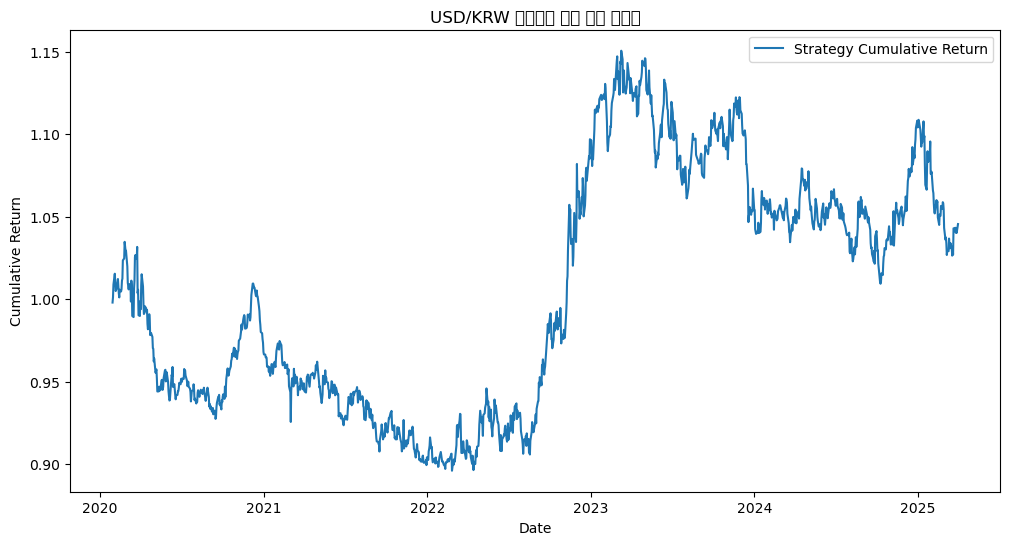

In [15]:
# 일일 수익률 계산
df['Return'] = df['Close'].pct_change()

# 전략 수익률 계산: 포지션에 따른 수익률 (포지션이 1이면 매수 상태, -1이면 매도 상태)
df['Strategy_Return'] = df['Return'] * df['Position']

# 누적 수익률 계산
df['Cumulative_Return'] = (1 + df['Strategy_Return']).cumprod()

# 누적 수익률 그래프
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Return'], label='Strategy Cumulative Return')
plt.title('USD/KRW 이동평균 전략 누적 수익률')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()



In [16]:
import numpy as np

# 기간 계산 (연 단위)
days = (df.index[-1] - df.index[0]).days
years = days / 365.25

# CAGR 계산
final_value = df['Cumulative_Return'].iloc[-1]
CAGR = (final_value ** (1 / years)) - 1

# MDD 계산
df['Cumulative_Max'] = df['Cumulative_Return'].cummax()
df['Drawdown'] = df['Cumulative_Return'] / df['Cumulative_Max'] - 1
MDD = df['Drawdown'].min()

print(f"CAGR: {CAGR:.2%}")
print(f"MDD: {MDD:.2%}")



CAGR: 0.87%
MDD: -13.42%
